# Whole Data Lake Processing Files

In [81]:
import os
import sys
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime, timedelta
import random
import patsy
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from statsmodels.regression.mixed_linear_model import MixedLMResults

file_path = 'DataLake.csv'
data = pd.read_csv(file_path, header=0)

## First running correlation Data

In [54]:
def weightedAverage(data):
    absMean = np.mean(data["NumUniqueDataPoints"]*data["Coef Abs"])/(sum(data["NumUniqueDataPoints"]))
    nonAbsMean = np.mean(data["NumUniqueDataPoints"]*data[""])/(sum(data["NumUniqueDataPoints"]))
    return [absMean, nonAbsMean]

def findCorr(dataSet, D1, D2):
    return np.corrcoef(dataSet[D1], dataSet[D2])[0, 1]

In [55]:
GrillTypes = ["Bent", "Holes", "Control"]
dataType1 = 'velocity_m_h'
dataType2 = 'PM25'

BentData = data[data["Grille"] == GrillTypes[0]]
NumBentEvents = len(set(BentData.Event))
HoleData = data[data["Grille"] == GrillTypes[1]]
NumHoleEvents = len(set(HoleData.Event))
ControlData = data[data["Grille"] == GrillTypes[2]]
NumControlEvents = len(set(ControlData.Event))

selectionDataSet = findCorr(BentData, dataType1, dataType2)

from scipy.stats import pearsonr
import numpy as np
from scipy.stats import norm

# Assuming you have var1, var2 as arrays, and a binary array/grating_indicator indicating the presence of the grating
# Split your data based on the grating presence
BentPM = BentData["PM25"]
BentVel = BentData["velocity_m_h"]

HolePM = HoleData["PM25"]
HoleVel = HoleData["velocity_m_h"]

ConPM = ControlData["PM25"]
ConVel = ControlData["velocity_m_h"]

# Calculate correlation coefficients
corr_with_BentGrating, bentSpeedP = pearsonr(BentPM, BentVel) #Pearson's Correlation Coefficients 
corr_with_HoleGrating, holeSpeedP = pearsonr(HolePM, HoleVel)
corr_without_grating, contSpeedP = pearsonr(ConPM, ConVel)


z_with_BentGrating = np.arctanh(corr_with_BentGrating)
z_with_HoleGrating = np.arctanh(corr_with_HoleGrating)
z_without_grating = np.arctanh(corr_without_grating)

# Standard errors
se_with_BentGrating = 1 / np.sqrt(len(BentPM) - 3)
se_with_HoleGrating = 1 / np.sqrt(len(HolePM) - 3)
se_without_grating = 1 / np.sqrt(len(ConPM) - 3)

# Standard error of the difference
se_diffBent = np.sqrt(se_with_BentGrating**2 + se_without_grating**2)
se_diffHole = np.sqrt(se_with_HoleGrating**2 + se_without_grating**2)

# Z-score for the difference
z_bent = (z_with_BentGrating - z_without_grating) / se_diffBent
z_hole = (se_with_HoleGrating - z_without_grating) / se_diffHole

# P-value
p_value_bent = 2 * (1 - norm.cdf(np.abs(z_bent)))  # Two-tailed test
p_value_hole = 2 * (1 - norm.cdf(np.abs(z_hole)))  # Two-tailed test

print(f"Velocity data ")
print(f"Average Velocity Bent Data: {np.average(BentData["velocity_m_h"]):.2f} m/h")
print(f"Average Velocity Bent Data: {np.average(ControlData["velocity_m_h"]):.2f} m/h")
print(f"Average Velocity Bent Data: {np.average(HoleData["velocity_m_h"]):.2f} m/h\n\n")

print(f"Direct Correlations in Vel and Particle Count")
print(f"Bent Correlation : {corr_with_BentGrating:.3f}")
print(f"P : {bentSpeedP:.3f}")
print(f"Hole Correlation : {corr_with_HoleGrating:.3f}")
print(f"P-value: {holeSpeedP:.3f}")
print(f"Control Correlation : {corr_without_grating:.3f}")
print(f"P-value: {contSpeedP:.3f}")
print("\n")


print(f"Comparing Mechanical Grille Populations ")
print(f"Bent Z-score : {z_bent:.4f}")
print(f"P-value on comparison to Control: {p_value_bent:.6f}")
print(f"Hole Z-score: {z_hole:.4f}")
print(f"P-value on comparison to Control: {p_value_hole:.6f}")

Wind speed data 
Average WindSpeed Bent Data: 11.67 m/h
Average WindSpeed Bent Data: 8.73 m/h
Average WindSpeed Bent Data: 9.71 m/h


Direct Correlations in Vel and Particle Count
Bent Correlation : -0.015
P : 0.225
Hole Correlation : 0.066
P-value: 0.000
Control Correlation : -0.113
P-value: 0.000


Comparing Mechanical Grille Populations 
Bent Z-score : 3.2789
P-value on comparison to Control: 0.001042
Hole Z-score: 4.2984
P-value on comparison to Control: 0.000017


Graph is here! NIce graph

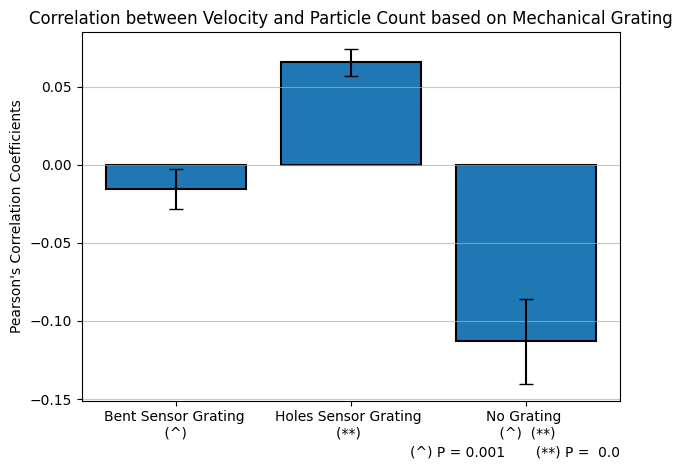

In [50]:
samples = ["Bent Sensor Grating \n (^) ", "Holes Sensor Grating \n(**) ", "No Grating \n (^)  (**)" ]
corr_coeffs = [corr_with_BentGrating,corr_with_HoleGrating,corr_without_grating]
std_errors = [se_with_BentGrating, se_with_HoleGrating, se_without_grating]  # Standard errors for error bars
p_values = [p_value_bent, p_value_hole, 100]  # Standard errors for error bars

bar_colors = ['tab:blue', 'tab:blue', 'tab:blue']

fig, ax = plt.subplots()
ax.grid(True, which='major', axis='y', linestyle='-', alpha=0.7)  # Add gridlines for easier comparison
ax.bar(samples, corr_coeffs,  color=bar_colors,  edgecolor='black', linewidth=1.5)

# Adding error bars
x_positions = range(len(samples))  # X positions for the error bars
ax.errorbar(x_positions, corr_coeffs, yerr=std_errors, fmt='none', capsize=5, color='black')

ax.set_ylabel("Pearson's Correlation Coefficients")
ax.set_title("Correlation between Velocity and Particle Count based on Mechanical Grating")
ax.set_xlabel("(^) P = "+ str(round(p_values[0],3)) + "       (**) P =  "+ str(round(p_values[1],3)), loc = "right")

plt.tight_layout()  # Adjust layout to make room for everything
plt.show()

Just a cleaner version I like

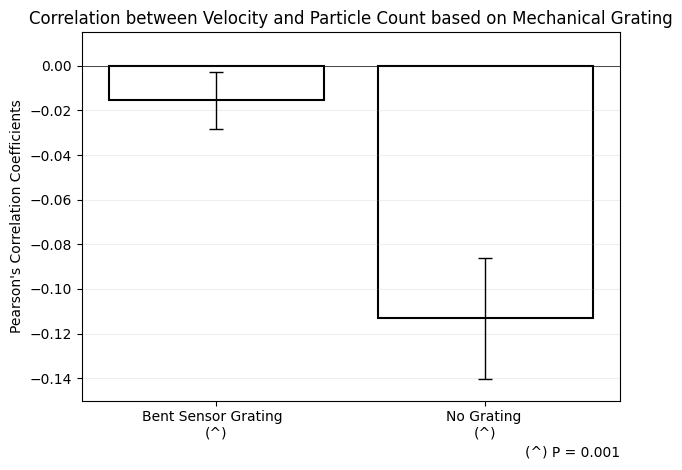

In [79]:
samples = ["Bent Sensor Grating  \n(^)", "No Grating \n(^)" ]
corr_coeffs = [corr_with_BentGrating,corr_without_grating]
std_errors = [se_with_BentGrating,  se_without_grating]  # Standard errors for error bars
p_values = [p_value_bent, 100]  # Standard errors for error bars

bar_colors = ['white',  'white']

fig, ax = plt.subplots()
ax.grid(True, which='major', axis='y', linestyle='-', alpha=0.2)  # Add gridlines for easier comparison
ax.bar(samples, corr_coeffs,  color=bar_colors,  edgecolor='black', linewidth=1.5)

# Adding error bars
x_positions = range(len(samples))  # X positions for the error bars
ax.errorbar(x_positions, corr_coeffs, yerr=std_errors, fmt='none', capsize=5, color='black', lw = 1)

plt.yticks(fontsize=10)
ax.plot([-1,3], [0,0], color = "black", lw = 0.5)
ax.set_xlabel("(^) P = 0.001", loc = 'right')
ax.set_ylabel("Pearson's Correlation Coefficients")


ax.set_title("Correlation between Velocity and Particle Count based on Mechanical Grating")

# ax.legend(title='Mechanical Grating Design')
plt.ylim(-0.15, 0.015)
plt.xlim(-0.5, 1.5)

plt.tight_layout()  # Adjust layout to make room for everything
plt.show()

Plotting all the data together for a regression analysis

Grille: Holes
slope: 0.17, intercept: 1e+01, r_value: 0.066, p_value: 1.7e-14, std_err: 0.023 

Grille: Bent
slope: -0.15, intercept: 1e+01, r_value: -0.015, p_value: 0.22, std_err: 0.13 

Grille: Control
slope: -0.73, intercept: 1.7e+01, r_value: -0.11, p_value: 2.8e-05, std_err: 0.17 



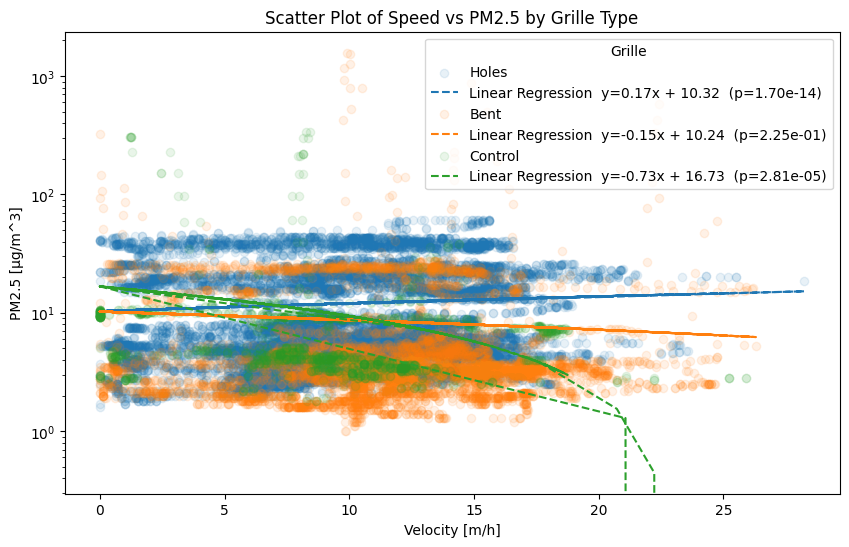

In [16]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
for grille_type in data['Grille'].unique():
    subset = data[data['Grille'] == grille_type]
    plt.scatter(subset['velocity_m_h'], subset['PM25'], label=grille_type, alpha=0.1)
    # Linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(subset['velocity_m_h'], subset['PM25'])
    print(f'Grille: {grille_type}')
    print(f'slope: {slope:.2}, intercept: {intercept:.2}, r_value: {r_value:.2}, p_value: {p_value:.2}, std_err: {std_err:.2} \n')
    # Add line of best fit
    plt.plot(subset['velocity_m_h'], intercept + slope * subset['velocity_m_h'], label=f'Linear Regression  y={slope:.2}x + {intercept:.2f}  (p={p_value:.2e})' , linestyle='--')
    
# Add labels and title
plt.xlabel('Velocity [m/h]')
plt.ylabel('PM25 [μg/m^3]')
plt.title('Scatter Plot of Speed vs PM25 by Grille Type')
plt.legend(title='Grille')
plt.yscale('log')
# plt.ylim(0, 60)

# Show the plot
plt.show()


## Manually setting up all Data Sets as per their Mechanical Grille

In [17]:
bent_data = data[data['Grille'] == 'Bent']

# Fit the linear model (Model A) with filtered data
model_a_bent = smf.ols('PM25 ~ velocity_m_h', data=bent_data).fit()
print("Model A Summary")
print(model_a_bent.summary())

# Fit the random effects model (Model B) with filtered data
model_b_bent = smf.mixedlm('PM25 ~ velocity_m_h', bent_data, groups=bent_data['DataSetCount'], re_formula='~velocity_m_h').fit()
print("\nModel B Summary")
print(model_b_bent.summary())

Model A Summary
                            OLS Regression Results                            
Dep. Variable:                   PM25   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.473
Date:                Wed, 05 Jun 2024   Prob (F-statistic):              0.225
Time:                        20:43:23   Log-Likelihood:                -32332.
No. Observations:                6180   AIC:                         6.467e+04
Df Residuals:                    6178   BIC:                         6.468e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.2433      1.5

In [18]:
holes_data = data[data['Grille'] == 'Holes']

# Fit the linear model (Model A) with filtered data
model_a_holes = smf.ols('PM25 ~ velocity_m_h', data=holes_data).fit()
print("Model A Summary")
print(model_a_holes.summary())

# Fit the random effects model (Model B) with filtered data
model_b_holes = smf.mixedlm('PM25 ~ velocity_m_h', holes_data, groups=holes_data['DataSetCount'], re_formula='~velocity_m_h').fit()
print("\nModel B Summary")
print(model_b_holes.summary())

Model A Summary
                            OLS Regression Results                            
Dep. Variable:                   PM25   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     58.98
Date:                Wed, 05 Jun 2024   Prob (F-statistic):           1.70e-14
Time:                        20:43:27   Log-Likelihood:                -52823.
No. Observations:               13653   AIC:                         1.057e+05
Df Residuals:                   13651   BIC:                         1.057e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.3160      0.2

In [19]:
control_data = data[data['Grille'] == 'Control']

# Fit the linear model (Model A) with filtered data
model_a_control = smf.ols('PM25 ~ velocity_m_h', data=control_data).fit()
print("Model A Summary")
print(model_a_control.summary())

# Fit the random effects model (Model B) with filtered data
model_b_control = smf.mixedlm('PM25 ~ velocity_m_h', control_data, groups=control_data['DataSetCount'], re_formula='~velocity_m_h').fit()
print("\nModel B Summary")
print(model_b_control.summary())

Model A Summary
                            OLS Regression Results                            
Dep. Variable:                   PM25   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     17.66
Date:                Wed, 05 Jun 2024   Prob (F-statistic):           2.81e-05
Time:                        20:43:32   Log-Likelihood:                -6611.9
No. Observations:                1364   AIC:                         1.323e+04
Df Residuals:                    1362   BIC:                         1.324e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       16.7287      1.7

/Users/kelseypool/Documents/Github/BrightBlock/myenv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/kelseypool/Documents/Github/BrightBlock/myenv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/kelseypool/Documents/Github/BrightBlock/myenv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


# Visualizing the Random Effects Models

## First step is the fixed effects 

Right off the bat I'm worried about the GIANT variation in the "control" or no air cover grille situation. It doesn't suprise me that there could be massive variation in an uncovered sensor - but it'd hope it would average out a little better

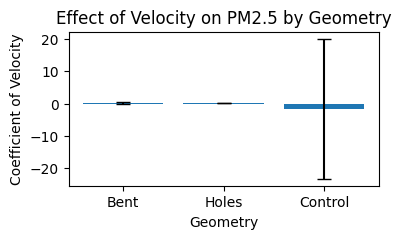

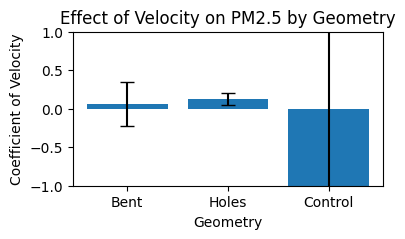

In [27]:
# Example for model summaries
summary_bent = model_b_bent.summary()
summary_holes = model_b_holes.summary()
summary_control = model_b_control.summary()

import matplotlib.pyplot as plt

# Function to extract fixed effect coefficients and their standard errors
def extract_fixed_effects(model):
    coef = float(model.params['velocity_m_h'])
    std_err = float(model.bse['velocity_m_h'])
    return coef, std_err

# Extract coefficients and standard errors for each geometry
bent_coef, bent_std_err = extract_fixed_effects(model_b_bent)
holes_coef, holes_std_err = extract_fixed_effects(model_b_holes)
control_coef, control_std_err = extract_fixed_effects(model_b_control)

# Create a dictionary for the coefficients and standard errors
coefficients = {
    'Bent': bent_coef,
    'Holes': holes_coef,
    'Control': control_coef
}

errors = {
    'Bent': bent_std_err,
    'Holes': holes_std_err,
    'Control': control_std_err
}

# Plotting the bar plot with actual standard errors
geometries = list(coefficients.keys())
values = list(coefficients.values())
error_values = list(errors.values())

plt.figure(figsize=(4, 2))
plt.bar(geometries, values, yerr=error_values, capsize=5)
plt.title('Effect of Velocity on PM25 by Geometry')
plt.xlabel('Geometry')
plt.ylabel('Coefficient of Velocity')
plt.show()


# Adjustment fit due to the giant variation in the control data 


# Plotting the bar plot with actual standard errors
geometries = list(coefficients.keys())
values = list(coefficients.values())
error_values = list(errors.values())

plt.figure(figsize=(4, 2))
plt.bar(geometries, values, yerr=error_values, capsize=5)
plt.title('Effect of Velocity on PM25 by Geometry')
plt.xlabel('Geometry')
plt.ylabel('Coefficient of Velocity')
plt.ylim(min(values) - max(error_values), max(values) + max(error_values))  # Adjust y-axis limits
plt.ylim(-1, 1)  # Adjust y-axis limits

plt.show()


/var/folders/pv/0dy6d06n4396k5v_kmt15hkw0000gn/T/ipykernel_31217/1376088974.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercepts = [effects[0] for effects in random_effects.values()]
/var/folders/pv/0dy6d06n4396k5v_kmt15hkw0000gn/T/ipykernel_31217/1376088974.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slopes = [effects[1] for effects in random_effects.values()]


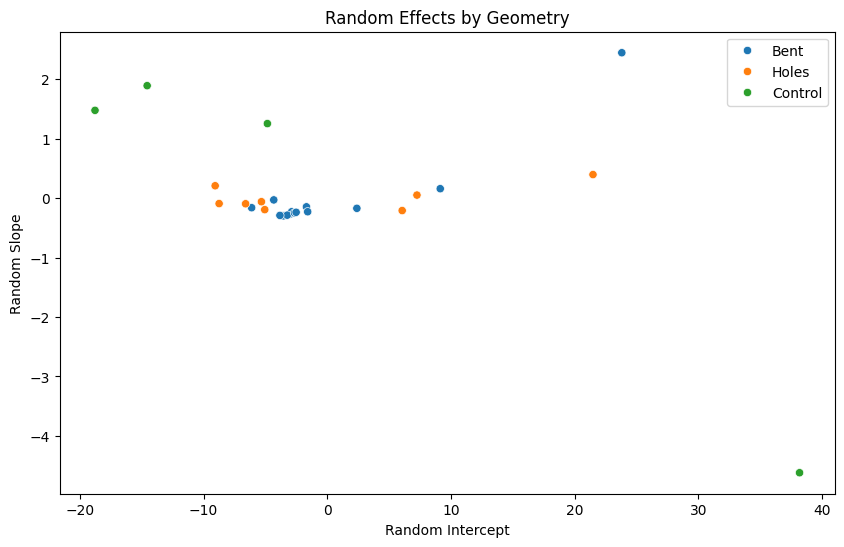

In [66]:
import seaborn as sns

# Function to extract random intercepts and slopes
def extract_random_effects(model):
    random_effects = model.random_effects
    intercepts = [effects[0] for effects in random_effects.values()]
    slopes = [effects[1] for effects in random_effects.values()]
    return intercepts, slopes

# Extract random effects for each geometry
bent_intercepts, bent_slopes = extract_random_effects(model_b_bent)
holes_intercepts, holes_slopes = extract_random_effects(model_b_holes)
control_intercepts, control_slopes = extract_random_effects(model_b_control)

# Create DataFrame for plotting
random_effects_data = pd.DataFrame({
    'Intercept': bent_intercepts + holes_intercepts + control_intercepts,
    'Slope': bent_slopes + holes_slopes + control_slopes,
    'Geometry': ['Bent']*len(bent_intercepts) + ['Holes']*len(holes_intercepts) + ['Control']*len(control_intercepts)
})

# Scatter plot of random effects
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Intercept', y='Slope', hue='Geometry', data=random_effects_data)
plt.title('Random Effects by Geometry')
plt.xlabel('Random Intercept')
plt.ylabel('Random Slope')
plt.legend()
plt.show()


Set really specific limits here <20 and can more of the data. I wonder if we should wait to fit anything before pulling out outliers?
Wish I could also re take data w/out any cover and just totally exposed and within the elements.  

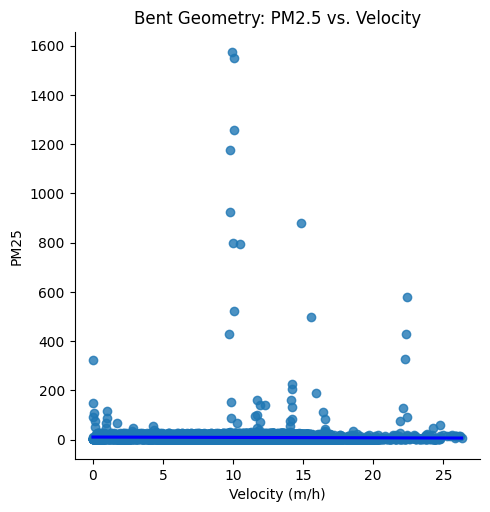

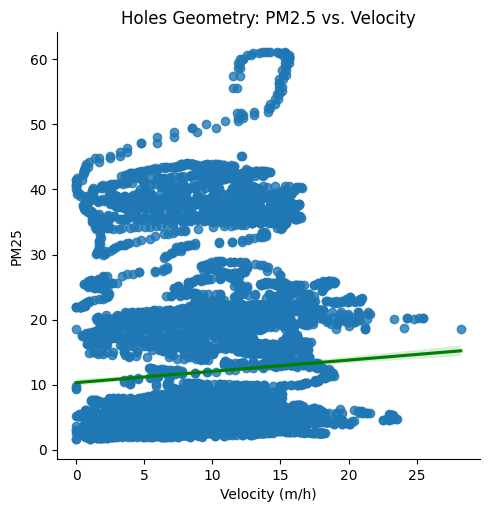

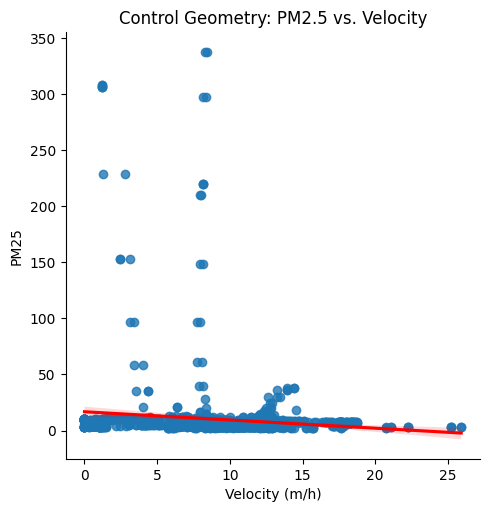

In [39]:
# Scatter plot for Bent Geometry with a blue line of best fit
g = sns.lmplot(x='velocity_m_h', y='PM25', data=bent_data, line_kws={'color': 'blue'})
g.set(title='Bent Geometry: PM2.5 vs. Velocity')
g.set_axis_labels('Velocity (m/h)', 'PM25')
plt.show()

# Scatter plot for Holes Geometry with a green line of best fit
g = sns.lmplot(x='velocity_m_h', y='PM25', data=holes_data, line_kws={'color': 'green'})
g.set(title='Holes Geometry: PM2.5 vs. Velocity')
g.set_axis_labels('Velocity (m/h)', 'PM25')
plt.show()

# Scatter plot for Control Geometry with a red line of best fit
g = sns.lmplot(x='velocity_m_h', y='PM25', data=control_data, line_kws={'color': 'red'})
g.set(title='Control Geometry: PM2.5 vs. Velocity')
g.set_axis_labels('Velocity (m/h)', 'PM25')
plt.show()

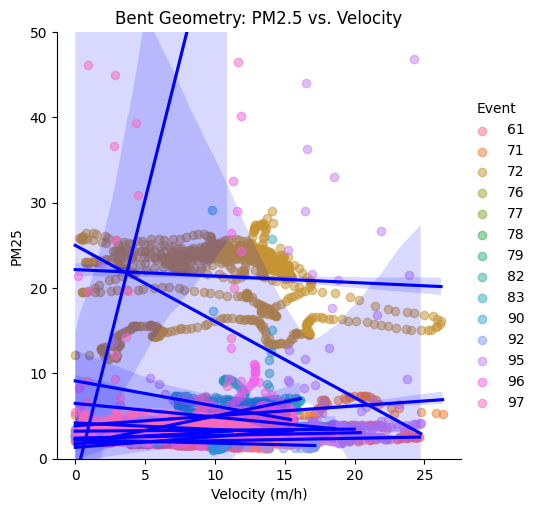

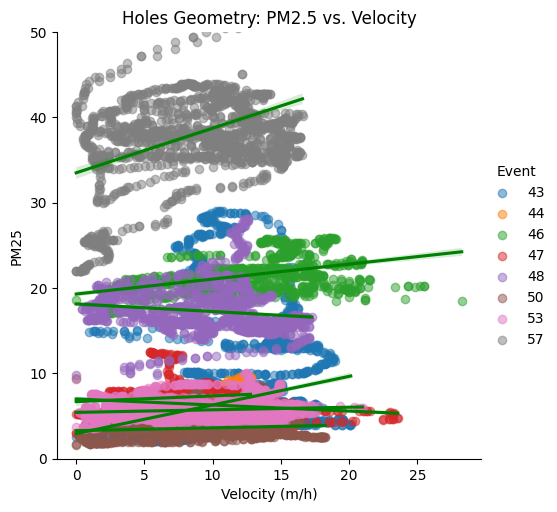

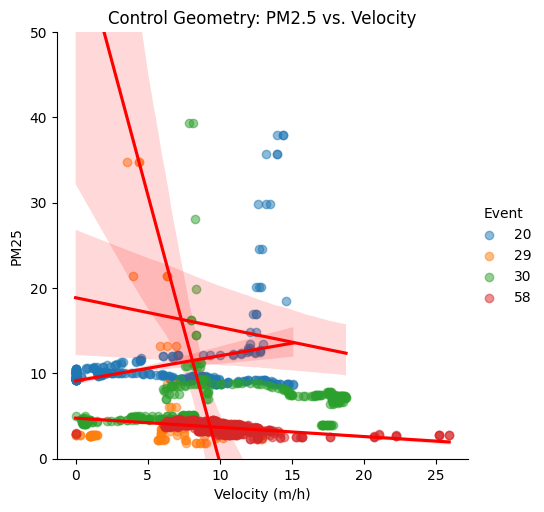

In [78]:


g = sns.lmplot(x='velocity_m_h', y='PM25', hue='Event', data=bent_data, scatter_kws={'alpha':0.5}, line_kws={'color': 'blue'})
g.set(title='Bent Geometry: PM2.5 vs. Velocity')
g.set_axis_labels('Velocity (m/h)', 'PM25')
g.set(ylim=(0, 50))  # Adjust the y-axis limits as needed
plt.show()


# Scatter plot for Holes Geometry with a green line of best fit
g = sns.lmplot(x='velocity_m_h', y='PM25', hue='Event', data=holes_data, scatter_kws={'alpha':0.5}, line_kws={'color': 'green'})
g.set(title='Holes Geometry: PM2.5 vs. Velocity')
g.set_axis_labels('Velocity (m/h)', 'PM25')
g.set(ylim=(0, 50))  # Adjust the y-axis limits as needed
plt.show()

# Scatter plot for Control Geometry with a red line of best fit
g = sns.lmplot(x='velocity_m_h', y='PM25', hue='Event', data=control_data, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
g.set(title='Control Geometry: PM2.5 vs. Velocity')
g.set_axis_labels('Velocity (m/h)', 'PM25')
g.set(ylim=(0, 50))  # Adjust the y-axis limits as needed
plt.show()

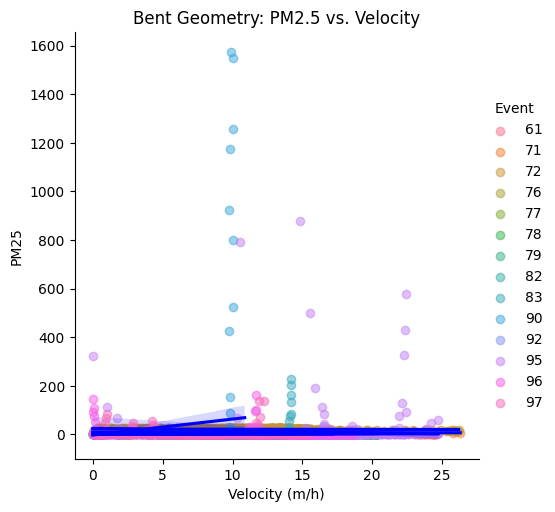

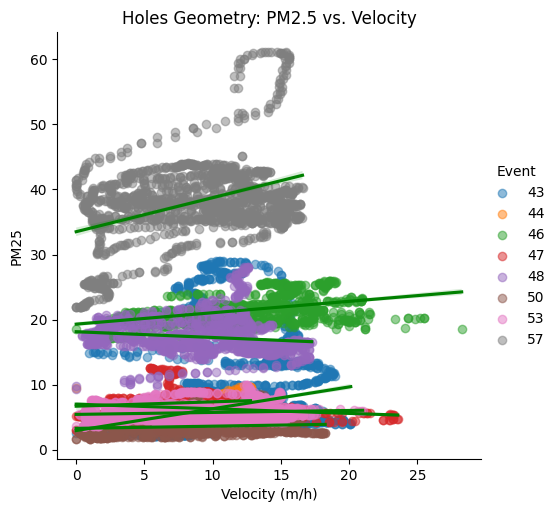

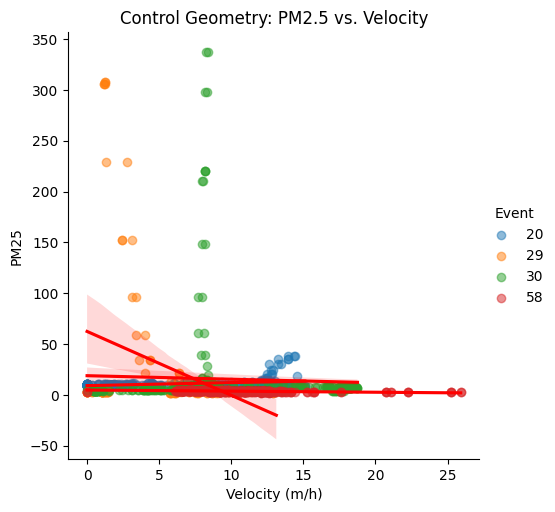

In [80]:
g = sns.lmplot(x='velocity_m_h', y='PM25', hue='Event', data=bent_data, scatter_kws={'alpha':0.5}, line_kws={'color': 'blue'})
g.set(title='Bent Geometry: PM2.5 vs. Velocity')
g.set_axis_labels('Velocity (m/h)', 'PM25')
plt.show()


# Scatter plot for Holes Geometry with a green line of best fit
g = sns.lmplot(x='velocity_m_h', y='PM25', hue='Event', data=holes_data, scatter_kws={'alpha':0.5}, line_kws={'color': 'green'})
g.set(title='Holes Geometry: PM2.5 vs. Velocity')
g.set_axis_labels('Velocity (m/h)', 'PM25')
plt.show()

# Scatter plot for Control Geometry with a red line of best fit
g = sns.lmplot(x='velocity_m_h', y='PM25', hue='Event', data=control_data, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
g.set(title='Control Geometry: PM2.5 vs. Velocity')
g.set_axis_labels('Velocity (m/h)', 'PM25')
plt.show()

## Adjusting the means to the same set

In [72]:

def adjust_data_by_group(data, group_col, value_col):
    # Group by the specified column and calculate the mean for each group
    group_means = data.groupby(group_col)[value_col].transform('median')
    
    # Subtract the group mean from each observation
    data[f'{value_col}_adjusted'] = data[value_col] - group_means
    
    return data

# Adjust the data for each dataset
bent_data_adjusted_means = adjust_data_by_group(bent_data, 'DataSetCount', 'PM25')
holes_data_adjusted_means = adjust_data_by_group(holes_data, 'DataSetCount', 'PM25')
control_data_adjusted_means = adjust_data_by_group(control_data, 'DataSetCount', 'PM25')

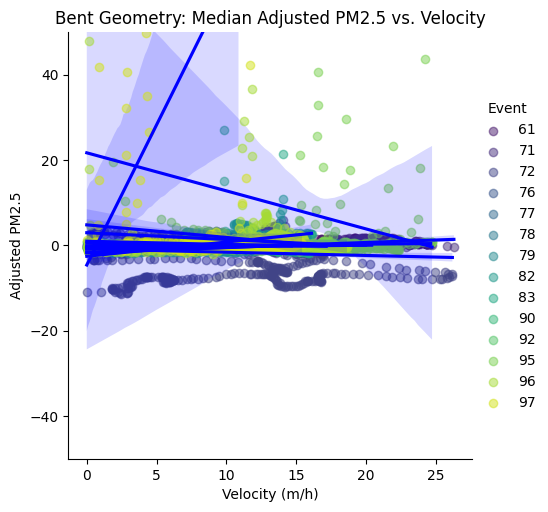

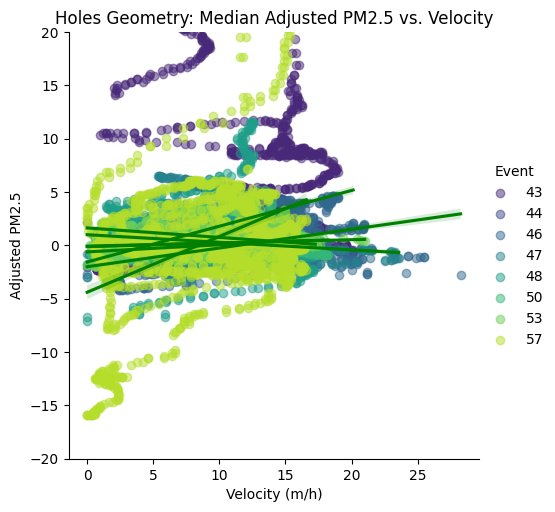

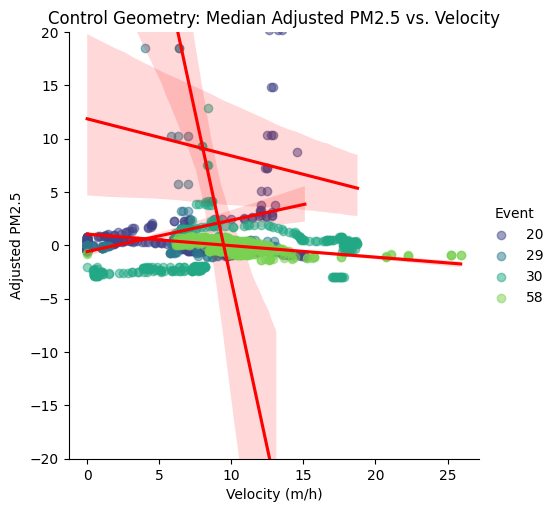

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot for Bent Geometry with adjusted PM25 and color-coded by Event
g = sns.lmplot(x='velocity_m_h', y='PM25_adjusted', hue='Event', data=bent_data_adjusted_means, scatter_kws={'alpha':0.5}, line_kws={'color': 'blue'}, palette='viridis')
g.set(title='Bent Geometry: Median Adjusted PM2.5 vs. Velocity')
g.set_axis_labels('Velocity (m/h)', 'Adjusted PM2.5')
g.set(ylim=(-50, 50))  # Adjust the y-axis limits as needed
plt.show()

# Scatter plot for Holes Geometry with adjusted PM25 and color-coded by Event
g = sns.lmplot(x='velocity_m_h', y='PM25_adjusted', hue='Event', data=holes_data_adjusted_means,  scatter_kws={'alpha':0.5}, line_kws={'color': 'green'}, palette='viridis')
g.set(title='Holes Geometry: Median Adjusted PM2.5 vs. Velocity')
g.set_axis_labels('Velocity (m/h)', 'Adjusted PM2.5')
g.set(ylim=(-20, 20))  # Adjust the y-axis limits as needed
plt.show()

# Scatter plot for Control Geometry with adjusted PM25 and color-coded by Event
g = sns.lmplot(x='velocity_m_h', y='PM25_adjusted', hue='Event', data=control_data_adjusted_means,  scatter_kws={'alpha':0.5}, line_kws={'color': 'red'}, palette='viridis')
g.set(title='Control Geometry: Median Adjusted PM2.5 vs. Velocity')
g.set_axis_labels('Velocity (m/h)', 'Adjusted PM2.5')
g.set(ylim=(-20, 20))  # Adjust the y-axis limits as needed
plt.show()

In [ ]:
# information on experimental design
group_list = ['control','patient1','patient2']
subs_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

# # read data into dataframe
# df_1way = pd.DataFrame(columns=["group", "my_value"])
# my_row = 0
# for ind_g, group in enumerate(group_list):
#     for sub in subs_list:
#         # generate random value here as example
#         my_val = np.random.normal(ind_g, 1, 1)[0]
#         df_1way.loc[my_row] = [group, my_val]
#         my_row = my_row + 1

# inspect data
sns.catplot(x="geometry", y="my_value", data=data, dodge=True, kind='violin', aspect=3)
plt.show()

In [94]:
# generate model for linear regression
my_model = smf.ols(formula='PM25 ~ Grille * velocity_m_h ', data=data) # + (velocity_m_h | Grille)

# fit model to data to obtain parameter estimates
my_model_fit = my_model.fit()

# print summary of linear regression
print(my_model_fit.summary())

# show anova table
anova_table = sm.stats.anova_lm(my_model_fit, typ=2)
print(anova_table)

                            OLS Regression Results                            
Dep. Variable:                   PM25   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     21.78
Date:                Wed, 19 Jun 2024   Prob (F-statistic):           8.06e-22
Time:                        14:18:42   Log-Likelihood:            -1.0017e+05
No. Observations:               21197   AIC:                         2.004e+05
Df Residuals:                   21191   BIC:                         2.004e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   